<a href="https://colab.research.google.com/github/sgmurphy00/TOOLS1/blob/google_collab_environment/ART_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Paul Scheidt
# Description: Implement simple Machine Learning Classification Model for SAT6 Database
# Implement ART toolbox to perform poisoning attack

In [2]:
# Problem Definition


In [3]:
# Real-World Impact

In [4]:
# Dataset Description

Quality of Data and Preprocessing

In [5]:
# Required Python Libraries
from google.colab import drive
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [6]:
# Initializing data, developing train/test splits
# Connecting to Deep Stat Database
drive.mount('/content/drive')




Mounted at /content/drive


In [7]:
DATA_PATH = '/content/drive/My Drive/DEEPSAT6/'
# Initializing training and valiadation Data Paths
train_data_path = DATA_PATH + '/X_train_sat6.csv'
train_label_path = DATA_PATH + 'y_train_sat6.csv'
test_data_path = DATA_PATH + 'X_test_sat6.csv'
test_label_path = DATA_PATH + 'y_test_sat6.csv'

# Storing data into pandas dataframes
x_train = pd.read_csv(train_data_path, header=None, dtype='uint8')
y_train = pd.read_csv(train_label_path, header=None, dtype='uint8')
x_test = pd.read_csv(test_data_path, header=None, dtype='uint8')
y_test = pd.read_csv(test_label_path, header=None, dtype='uint8')

# Investigating Shape of Pandas DataFrame
print("Train data shape: ", x_train.shape)
print("Train label shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test label shape: ", y_test.shape)

Train data shape:  (324000, 3136)
Train label shape:  (324000, 6)
Test data shape:  (81000, 3136)
Test label shape:  (81000, 6)


In [8]:
# Restructuring Training and Test Images to be 3 layers, RGB
x_train = x_train.values.reshape([-1,28,28,4])
x_test = x_test.values.reshape([-1,28,28,4])

x_train.shape, x_test.shape

((324000, 28, 28, 4), (81000, 28, 28, 4))

Text(0.5, 1.0, '0    0\n1    0\n2    0\n3    0\n4    0\n5    1\nName: 3, dtype: uint8')

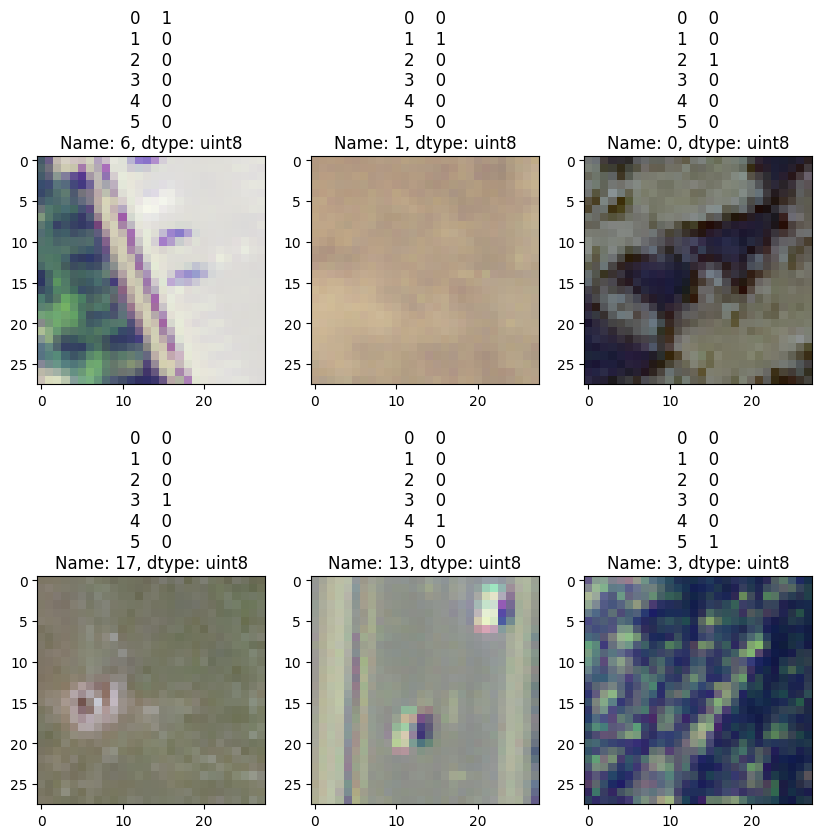

In [12]:
# This Code Block Highlights examples of images from each class


fig = plt.figure(figsize = (10,10))
rows = 2
cols = 3


# plotting Class A
ax1 = fig.add_subplot(rows, cols, 1)
img_A = x_train[6].reshape([28,28,4])[:,:,:3]
label_A = y_train.iloc[6]
plt.imshow(img_A)
ax1.set_title(label_A)

# Plotting Class B
ax2 = fig.add_subplot(rows, cols, 2)
img_B = x_train[1].reshape([28,28,4])[:,:,:3]
label_B = y_train.iloc[1]
plt.imshow(img_B)
ax2.set_title(label_B)

# plotting Class C
ax3 = fig.add_subplot(rows, cols, 3)
img_C = x_train[0].reshape([28,28,4])[:,:,:3]
label_C = y_train.iloc[0]
plt.imshow(img_C)
ax3.set_title(label_C)

# Plotting Class D
ax4 = fig.add_subplot(rows, cols, 4)
img_D = x_train[17].reshape([28,28,4])[:,:,:3]
label_D = y_train.iloc[17]
plt.imshow(img_D)
ax4.set_title(label_D)

# plotting Class E
ax5 = fig.add_subplot(rows, cols,5)
img_E = x_train[13].reshape([28,28,4])[:,:,:3]
label_E = y_train.iloc[13]
plt.imshow(img_E)
ax5.set_title(label_E)

# Plotting Class F
ax6 = fig.add_subplot(rows, cols, 6)
img_F = x_train[3].reshape([28,28,4])[:,:,:3]
label_F = y_train.iloc[3]
plt.imshow(img_F)
ax6.set_title(label_F)